In [1]:
import glob
import sys
sys.path.append('../python/')
from json2graph import jsonFile2graph
from graphUtils import plot_graph
from statsUtils import whichFitsBetter

# Read observable graphs

In [2]:
import networkx as nx
import glob
import json
import os
#"/home/antolin/wakame/randomStuff/RealisticModels/EcoreReal/*.json"
files = glob.glob("../realGraphs/RDS/R2/*.json")

Gs = []
for file in files:
    Gs.append(jsonFile2graph(file))


## Ploting rds

In [3]:
import random
random.seed(123)

sample = random.sample(Gs,3)

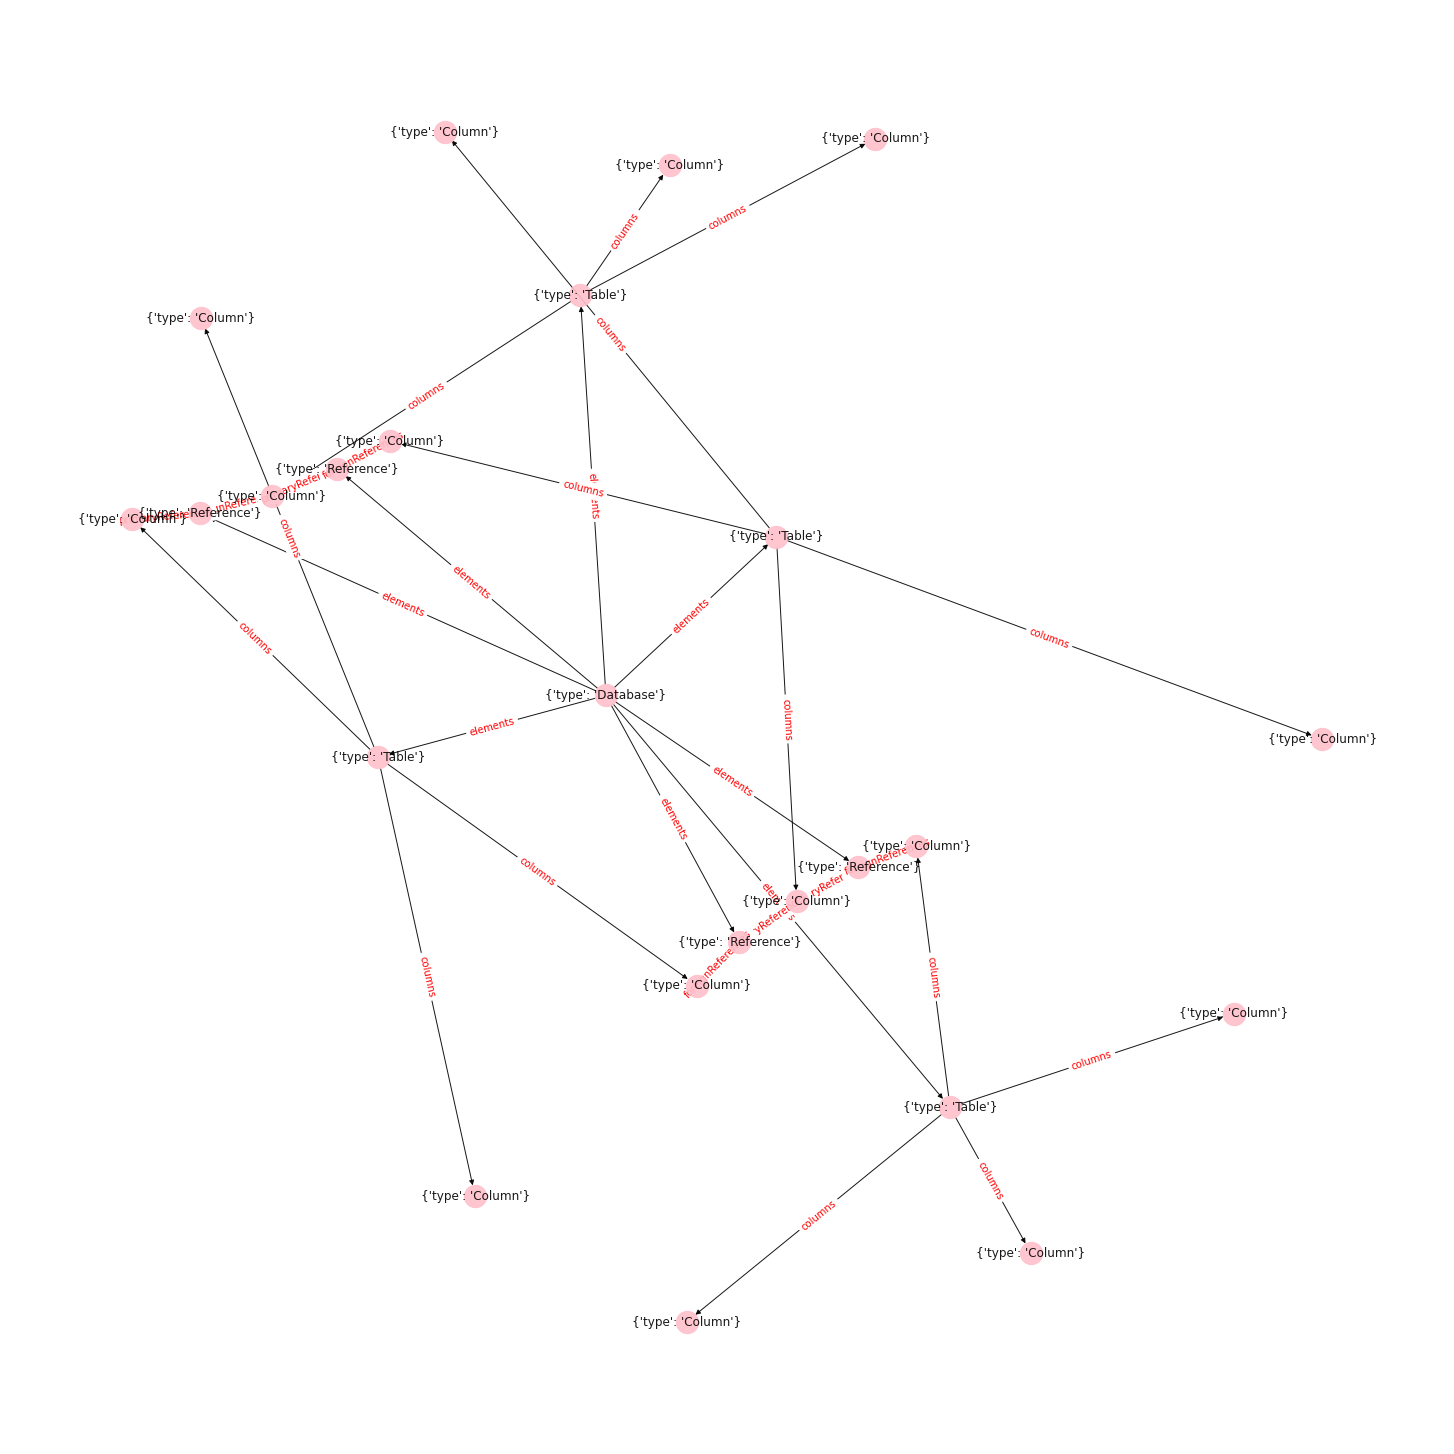

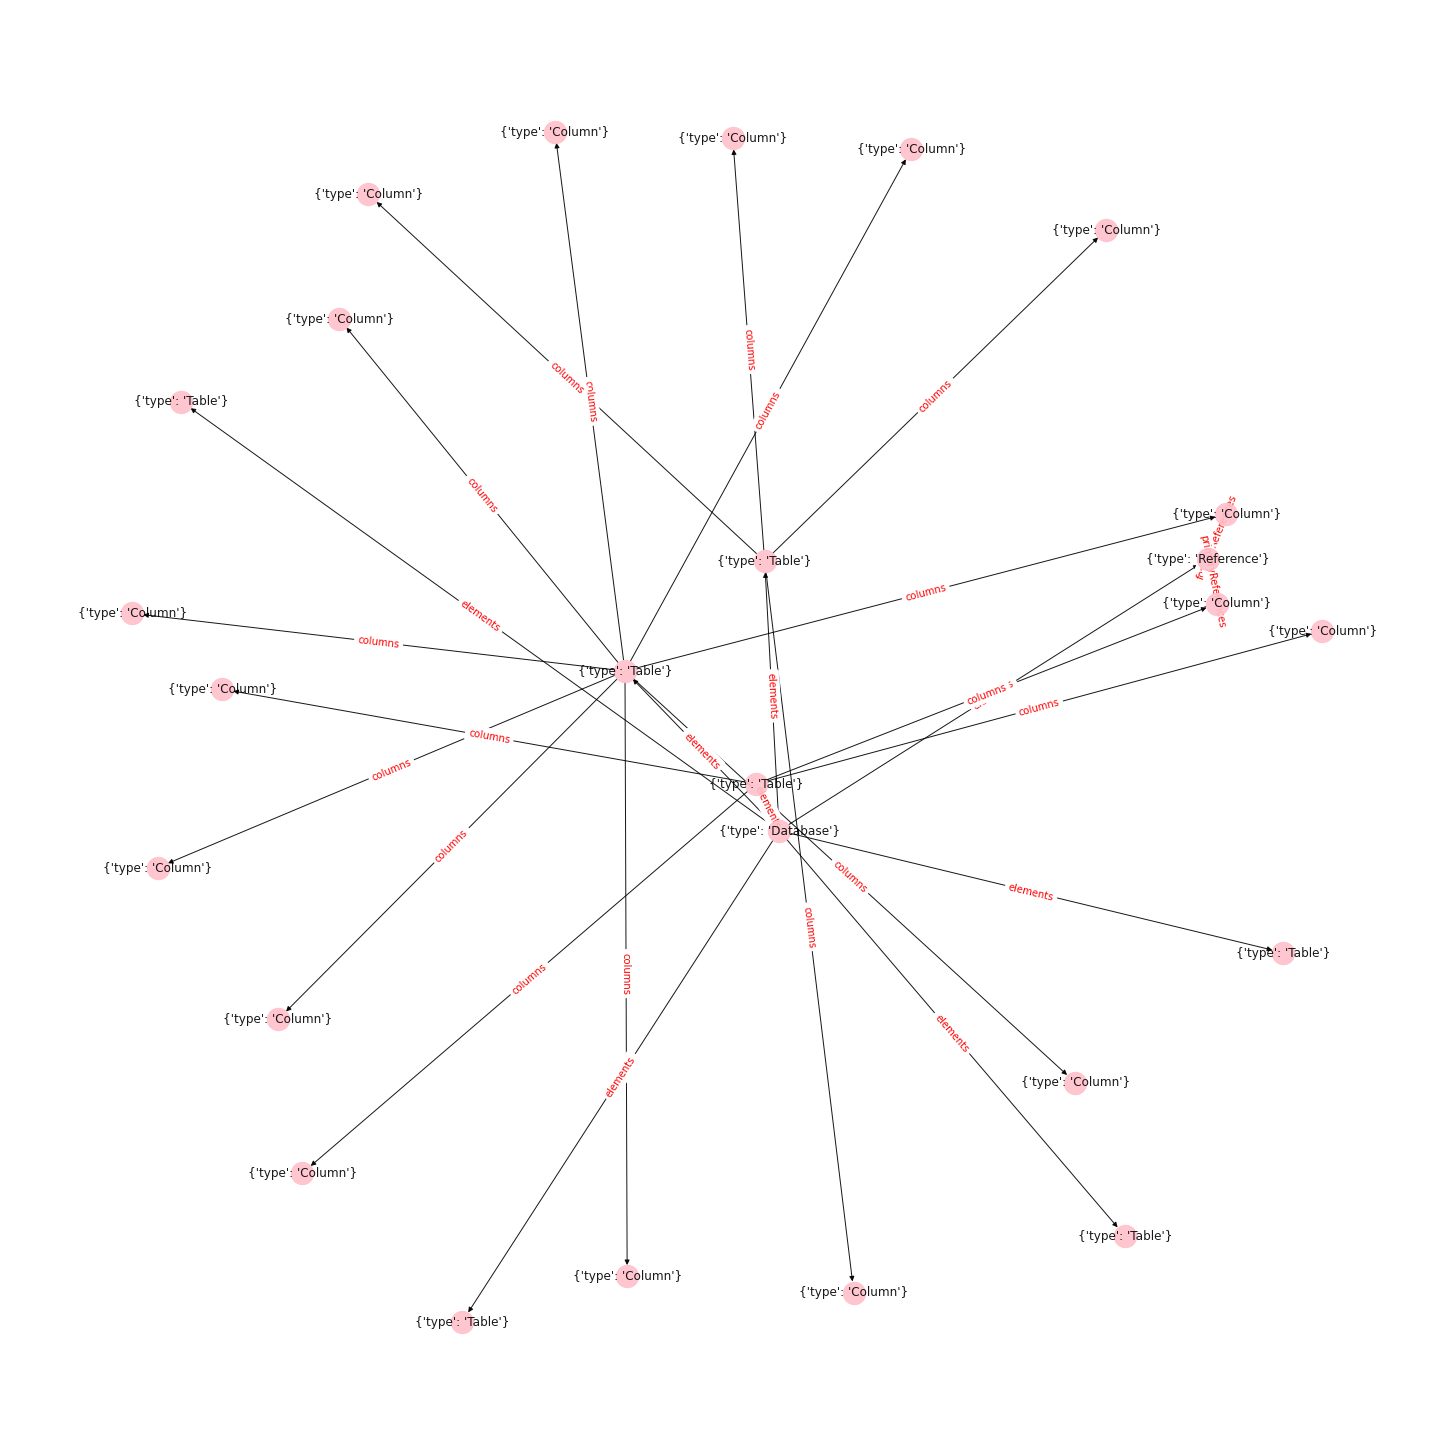

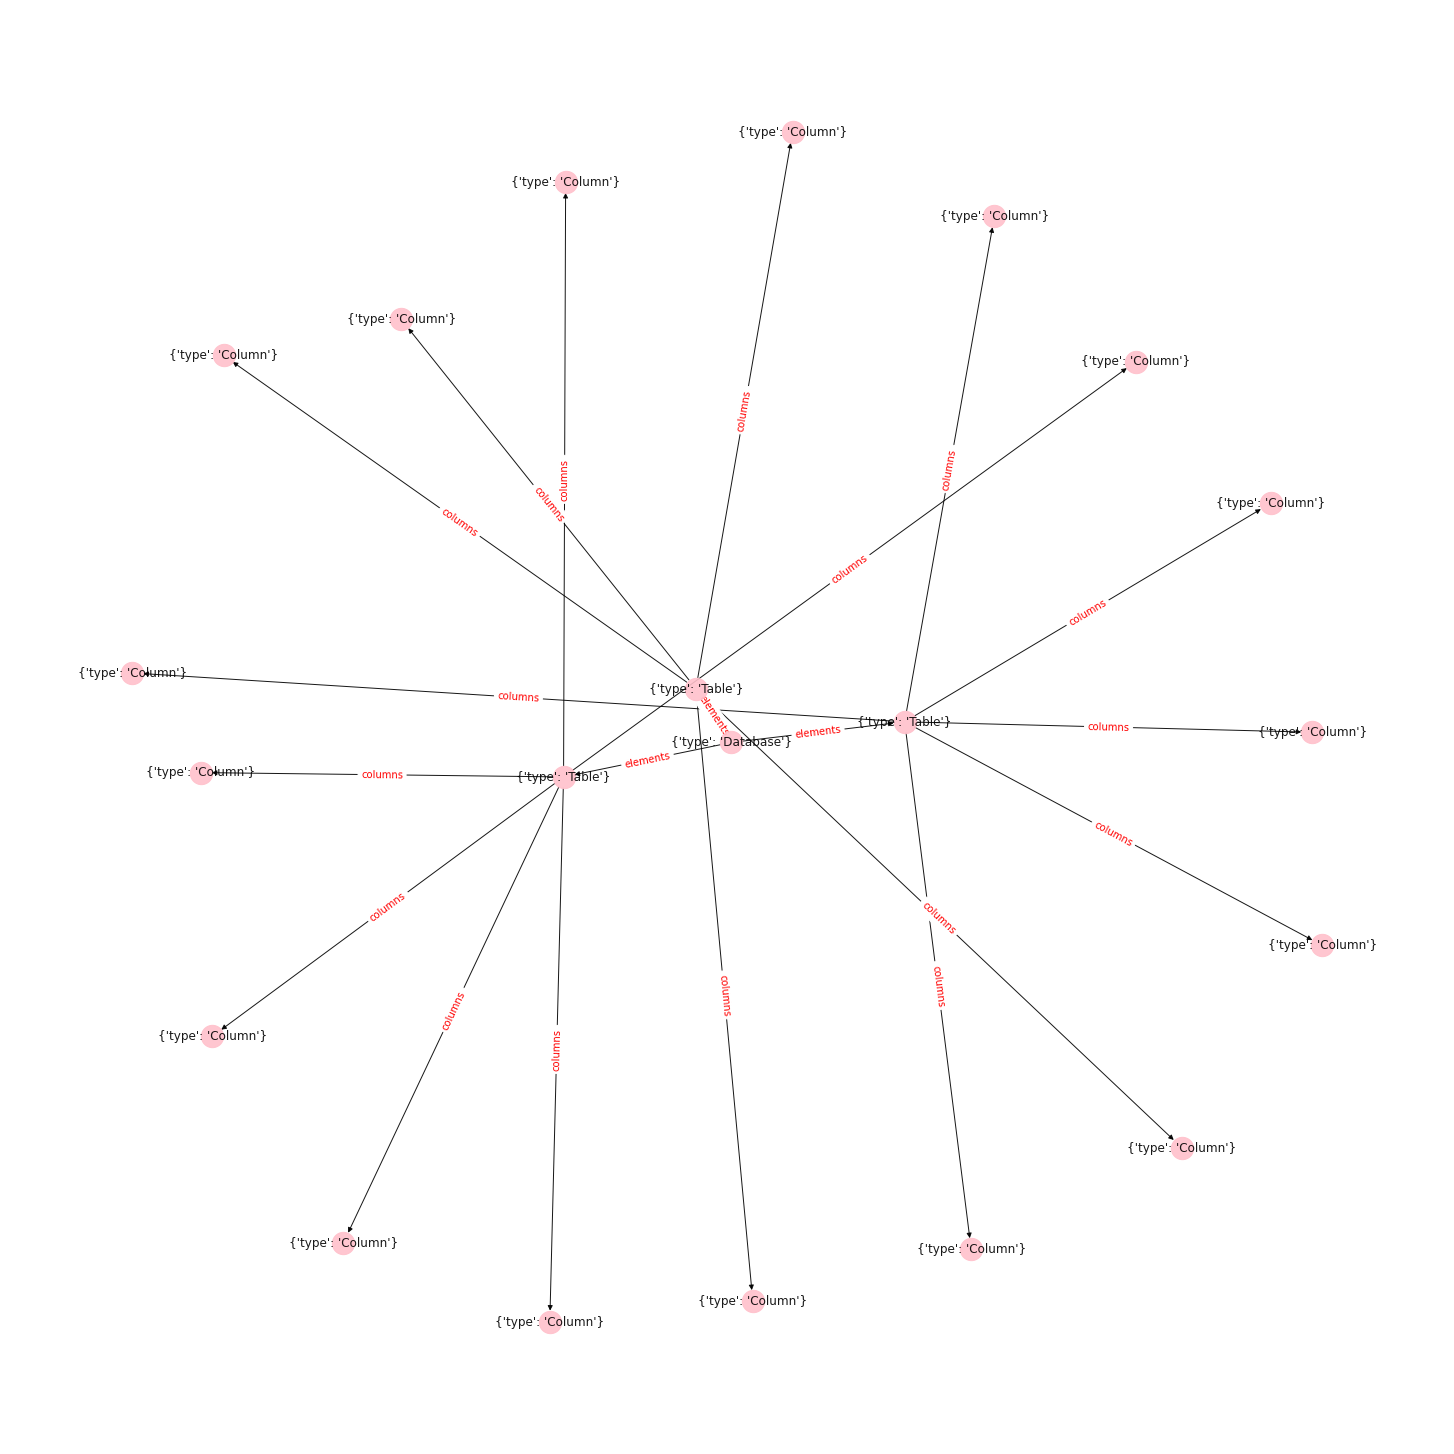

In [4]:
for s in sample:
    plot_graph(s)

All models have only one statechart.

In [5]:
cont = 0
for G in Gs:
    for n in G:
        if (G.nodes[n]['type']=='Database'):
            cont = cont + 1
cont == len(Gs)

True

# Random EMF

## Number of tables per database

(array([0.004, 0.064, 0.172, 0.1  , 0.116, 0.132, 0.092, 0.048, 0.096,
        0.048, 0.04 , 0.052, 0.008, 0.   , 0.004, 0.   , 0.004, 0.012,
        0.   , 0.004, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.004, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4

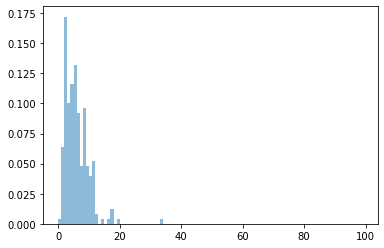

In [14]:
import numpy as np
import matplotlib.pyplot as plt

numberSubvertex = []
for G in Gs:
    for n in G:
        if G.nodes[n]['type'] =='Database':
            cont = 0
            for e in G[n]:
                if (G.nodes[e]['type'] == 'Table'):
                    cont = cont + 1
            numberSubvertex.append(cont)
            
bins = np.arange(0, 100, 1)
plt.hist(numberSubvertex, bins = bins, alpha=0.5, density = True)

In [15]:
best = whichFitsBetter(numberSubvertex)
print(best)
#print(r,p)
#print(best)

Optimization terminated successfully.
         Current function value: 2.577193
         Iterations: 38
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.757858
         Iterations: 24
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 2.833068
         Iterations: 13
         Function evaluations: 26
{'dis': 'nbinom', 'params': (4.0, 0.4356815292147317)}


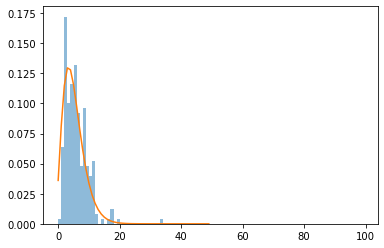

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.stats import nbinom
from scipy.stats import poisson


t = np.arange(0, 50, 1)
d = nbinom.pmf(t, 4.0, 0.435681, 0)
#np.exp(-np.mean(numberClassifiers))*np.power(np.mean(numberClassifiers), t)/factorial(t)
plt.hist(numberSubvertex, bins = bins, alpha=0.5, density = True)
plt.plot(t, d, '-')
plt.show()

## Columns per table

(array([0.06414825, 0.05844619, 0.17605132, 0.17248753, 0.13827512,
        0.1147541 , 0.07056308, 0.04561654, 0.03136137, 0.02779758,
        0.02637206, 0.0171062 , 0.01069138, 0.01568068, 0.00926586,
        0.00427655, 0.00285103, 0.00285103, 0.        , 0.00142552,
        0.00142552, 0.00142552, 0.        , 0.00498931, 0.        ,
        0.        , 0.00071276, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00071276, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00071276, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

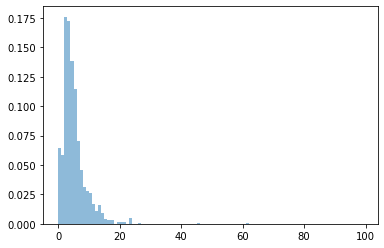

In [18]:
numberSubvertex = []
for G in Gs:
    for n in G:
        if G.nodes[n]['type'] =='Table':
            cont = 0
            for e in G[n]:
                if (G.nodes[e]['type'] == 'Column'):
                    cont = cont + 1
            numberSubvertex.append(cont)
            
bins = np.arange(0, 100, 1)
plt.hist(numberSubvertex, bins = bins, alpha=0.5, density = True)

In [19]:
best = whichFitsBetter(numberSubvertex)
print(best)

Optimization terminated successfully.
         Current function value: 2.532311
         Iterations: 36
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 2.830437
         Iterations: 25
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: 2.954411
         Iterations: 13
         Function evaluations: 26
{'dis': 'nbinom', 'params': (3.0, 0.3630784400563586)}


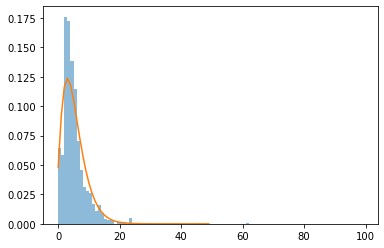

In [20]:
t = np.arange(0, 50, 1)
d = nbinom.pmf(t, 3, 0.3630, 0)
#np.exp(-np.mean(numberClassifiers))*np.power(np.mean(numberClassifiers), t)/factorial(t)
plt.hist(numberSubvertex, bins = bins, alpha=0.5, density = True)
plt.plot(t, d, '-')
plt.show()

## Indexes per table

(array([0.98574483, 0.01140413, 0.00285103, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

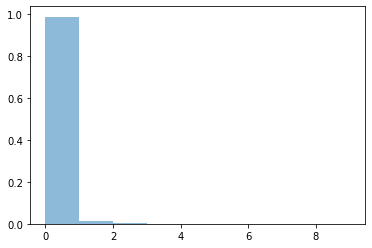

In [21]:
numberSubvertex = []
for G in Gs:
    for n in G:
        if G.nodes[n]['type'] =='Table':
            cont = 0
            for e in G[n]:
                if (G.nodes[e]['type'] == 'Index'):
                    cont = cont + 1
            numberSubvertex.append(cont)
            
bins = np.arange(0, 10, 1)
plt.hist(numberSubvertex, bins = bins, alpha=0.5, density = True)

In [22]:
best = whichFitsBetter(numberSubvertex)
print(best)

Optimization terminated successfully.
         Current function value: 0.082609
         Iterations: 28
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.477834
         Iterations: 12
         Function evaluations: 25
Optimization terminated successfully.
         Current function value: 0.088676
         Iterations: 5
         Function evaluations: 10
{'dis': 'norm', 'params': (0.017106200997861726, 0.15005214388528315)}


## Frefs per Colum

(array([8.58365164e-01, 1.36745607e-01, 4.12528648e-03, 4.58365164e-04,
        3.05576776e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

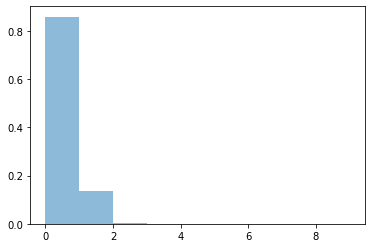

In [24]:
number = []
for G in Gs:
    for n in G:
        if (G.nodes[n]['type'] == 'Column'):
            cont = 0
            for e in G[n]:
                for e2 in G[n][e]:
                     if (G[n][e][e2]['type'] == 'foreignReferences'):
                        cont = cont + 1
            number.append(cont)
bins = np.arange(0, 10, 1)
plt.hist(number, bins = bins, alpha=0.5, density = True)

In [25]:
best = whichFitsBetter(number)
print(best)

Optimization terminated successfully.
         Current function value: 0.437584
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.434635
         Iterations: 8
         Function evaluations: 16
{'dis': 'poisson', 'params': 0.14759358288770053}


/home/antolin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/home/antolin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


## Prefs per column

(array([8.89533995e-01, 8.67838044e-02, 1.43621085e-02, 7.02826585e-03,
        1.22230710e-03, 4.58365164e-04, 4.58365164e-04, 1.52788388e-04,
        0.00000000e+00]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

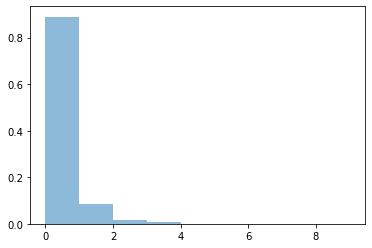

In [28]:
number = []
for G in Gs:
    for n in G:
        if (G.nodes[n]['type'] == 'Column'):
            cont = 0
            for e in G[n]:
                for e2 in G[n][e]:
                     if (G[n][e][e2]['type'] == 'primaryReferences'):
                        cont = cont + 1
            number.append(cont)
bins = np.arange(0, 10, 1)
plt.hist(number, bins = bins, alpha=0.5, density = True)

In [29]:
best = whichFitsBetter(number)
print(best)

Optimization terminated successfully.
         Current function value: 0.429944
         Iterations: 23
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: 0.706850
         Iterations: 17
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.462929
         Iterations: 8
         Function evaluations: 16
{'dis': 'poisson', 'params': 0.14759358288770053}


## IndexColumns

(array([0.45833333, 0.29166667, 0.16666667, 0.08333333, 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

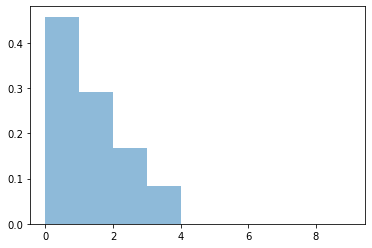

In [30]:
numberSubvertex = []
for G in Gs:
    for n in G:
        if G.nodes[n]['type'] =='Index':
            cont = 0
            for e in G[n]:
                if (G.nodes[e]['type'] == 'IndexColumn'):
                    cont = cont + 1
            numberSubvertex.append(cont)
            
bins = np.arange(0, 10, 1)
plt.hist(numberSubvertex, bins = bins, alpha=0.5, density = True)

In [31]:
best = whichFitsBetter(numberSubvertex)
print(best)

Optimization terminated successfully.
         Current function value: 1.254829
         Iterations: 58
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 1.389439
         Iterations: 19
         Function evaluations: 39
Optimization terminated successfully.
         Current function value: 1.256678
         Iterations: 10
         Function evaluations: 20
{'dis': 'uniform', 'params': (0, 3)}


# For VIATRA and Atlan, estimating the scope using KDE

## Viatra

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import numpy as np

numberObjects = [[len([n for n in G])] for G in Gs]

params = {'bandwidth': np.logspace(-2, -1, 20),
         'kernel':['gaussian', 'tophat']}
grid = GridSearchCV(KernelDensity(), params, n_jobs = 8)
grid.fit(np.array(numberObjects))
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
print("best kernel: {0}".format(grid.best_estimator_.kernel))

best bandwidth: 0.1
best kernel: gaussian


/home/antolin/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:813: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


In [12]:
kde = grid.best_estimator_
new_data = kde.sample(1000, random_state=0) #check this <-----
new_data = new_data.reshape(-1)
new_data

array([  9.98983027,  19.00192794,  19.18495912,  24.97858333,
        11.95009834,  10.00213512,  65.90808866,  20.01927538,
        23.96349448, 133.82086725,  37.99414134,  20.96824569,
         5.83675767,   4.99328658, 127.1489356 ,  10.05213037,
        11.06119272,   9.86585033,  16.04768984,  31.01484496,
        11.05290452,  31.04226286,  19.86402193,  14.99585992,
         9.92421291,   8.99499159,  41.91025991,  21.13124704,
        45.91410276,  37.91010578,   6.00745864,   4.89229009,
       183.95753367,   5.91700354,  21.14111721,  59.07858038,
        64.99425305,  58.96087829,   8.09409176,  14.04052041,
         6.04980524,  65.99738078,  66.831177  ,  58.9887534 ,
        17.94675101,  21.06450553,  62.10118424,  69.9342049 ,
        10.04683852,  91.1735879 ,   5.93322873,  66.16819217,
        49.91474142,  27.00229598,  61.99888544,   6.00114989,
         3.9162322 ,  31.94088169,  42.93322797,  12.03269626,
        52.03300351,  28.22259443,  28.1370989 ,  36.94

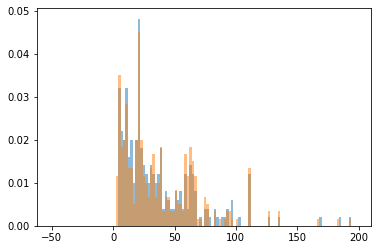

In [5]:
import matplotlib.pyplot as plt
size_bin=2
bins = np.arange(-50, 200, size_bin)
numberObjects = [len([n for n in G]) for G in Gs]
hist = plt.hist(numberObjects, bins = bins, alpha=0.5,density=True)
plt.hist(new_data, bins = bins, alpha=0.5,density=True)
probs = hist[0]
probs = (probs/np.sum(probs))
objs = hist[1]

In [12]:
import numpy as np
import random
i = 0
for s in new_data:
    with open('../configurationFiles/RDS/model.vsconfig', 'r') as file:
        data = file.read()
    x = data.replace("#node += 20..21", "#node += "+str(int(s)))
    x = x.replace("debug =\t\t\t\"outputs/debug\"","debug =\t\t\t\"outputs"+str(i)+"/debug\"")
    x = x.replace("log =\t\t\t\"outputs/log.txt\"","log =\t\t\t\"outputs"+str(i)+"/log.txt\"")
    x = x.replace("output =\t\t\"outputs/models\"","output =\t\t\"outputs"+str(i)+"/models\"")
    x = x.replace("runs = 10","runs = 1")
    with open("../configurationFiles/RDS/VIATRA/rdsGen"+str(i)+".vsconfig", "w") as text_file:
        text_file.write(x)
        i = i + 1
    

In [14]:
import numpy as np
import random
i = 0
for s in new_data:
    if int(s) > 20:
        continue
    with open('../configurationFiles/RDS/modelAlloy.vsconfig', 'r') as file:
        data = file.read()
    x = data.replace("#node += 20..21", "#node += "+str(int(s)))
    x = x.replace("debug =\t\t\t\"outputs/debug\"","debug =\t\t\t\"outputs"+str(i)+"/debug\"")
    x = x.replace("log =\t\t\t\"outputs/log.txt\"","log =\t\t\t\"outputs"+str(i)+"/log.txt\"")
    x = x.replace("output =\t\t\"outputs/models\"","output =\t\t\"outputs"+str(i)+"/models\"")
    x = x.replace("ViatraSolver", "AlloySolver")
    with open("../configurationFiles/RDS/ALLOY/rdsGen"+str(i)+".vsconfig", "w") as text_file:
        text_file.write(x)
        i = i + 1

## Atlan

In [19]:
import numpy as np
numberObjects = [n[0] for n in numberObjects]
deg_objects = [np.mean([G.out_degree(n) for n in G]) for G in Gs]
objects_deg = np.array(list(zip(numberObjects,deg_objects)))
objects_deg

array([[ 18.        ,   1.61111111],
       [ 21.        ,   0.95238095],
       [ 43.        ,   1.62790698],
       [ 31.        ,   2.12903226],
       [ 21.        ,   1.14285714],
       [ 11.        ,   1.27272727],
       [ 77.        ,   1.55844156],
       [ 75.        ,   1.41333333],
       [ 19.        ,   1.15789474],
       [  7.        ,   0.85714286],
       [ 24.        ,   1.45833333],
       [ 17.        ,   1.41176471],
       [ 14.        ,   1.5       ],
       [ 24.        ,   1.625     ],
       [  4.        ,   0.75      ],
       [ 59.        ,   1.3220339 ],
       [ 96.        ,   1.73958333],
       [127.        ,   0.99212598],
       [ 11.        ,   1.27272727],
       [ 22.        ,   1.31818182],
       [ 63.        ,   1.55555556],
       [ 10.        ,   1.3       ],
       [ 21.        ,   0.95238095],
       [ 96.        ,   1.40625   ],
       [ 60.        ,   1.58333333],
       [ 27.        ,   1.55555556],
       [ 37.        ,   1.62162162],
 

In [20]:
params = {'bandwidth': np.logspace(-2, -1, 20),
         'kernel':['gaussian', 'tophat']}
grid2 = GridSearchCV(KernelDensity(), params, n_jobs = 10)
grid2.fit(objects_deg)
print("best bandwidth: {0}".format(grid2.best_estimator_.bandwidth))
print("best kernel: {0}".format(grid2.best_estimator_.kernel))

best bandwidth: 0.1
best kernel: gaussian


/home/antolin/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:813: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


In [22]:
kde2 = grid2.best_estimator_
new_data2 = kde2.sample(500, random_state=0)

In [23]:
import numpy as np
import random
import subprocess
i = 0
for s in new_data2:
    subprocess.call(['java', '-jar', '../java/instantiate.jar', 
                     '-m','/home/antolin/wakame/RealisticModels/java/GraphGeneration/src/main/resources/models/rdsSimplified.ecore',
                    '-f','-n','1','-s',str(s[0]),'-d',str(s[1]),'-o',
                     '/home/antolin/wakame/AssessingRealisticGenerators/syntheticModels/RAND/RDS/'+str(i)+'/',
                    '-e',str(i)])
    i = i + 1